In [2]:
from monte_carlo import *
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [3]:
ndim = 2
nsamples = 1000

target = densities.Camel(ndim)
# add .count attributes to pdf and pot_gradient methods
util.count_calls(target, 'pdf', 'pot_gradient')
start = np.full(ndim, 1/3)

# Markov Updates
The package defines the abstract `MarkovUpdate` which implements a general `sample` function
based on the `next_state(current)` function, that each concrete update must override.
The sample returned is an instance of `MarkovSample` and contains the generated sample as `data`
and provides information such as the mean, variance, and acceptance rate for Metropolis updates.

## Metropolis Updates
Metropolis updates are generally subclasses of `MetropolisUpdate`, which is abstract.
The "default" Metropolis (Hasting) update is implemented in `DefaultMetropolis`.
The metheods, on instantiation, take the sample dimension and a callable target probability
as arguments. The pdf can be a `Density` object, but as opposed to Hamiltonian updates, they
can also be simple functions.

## Default Metropolis Hasting

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  0.35432833500090055
pdf calls:  1000
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.50429561 0.49405495],[0.03264332 0.03386337],None,0.143


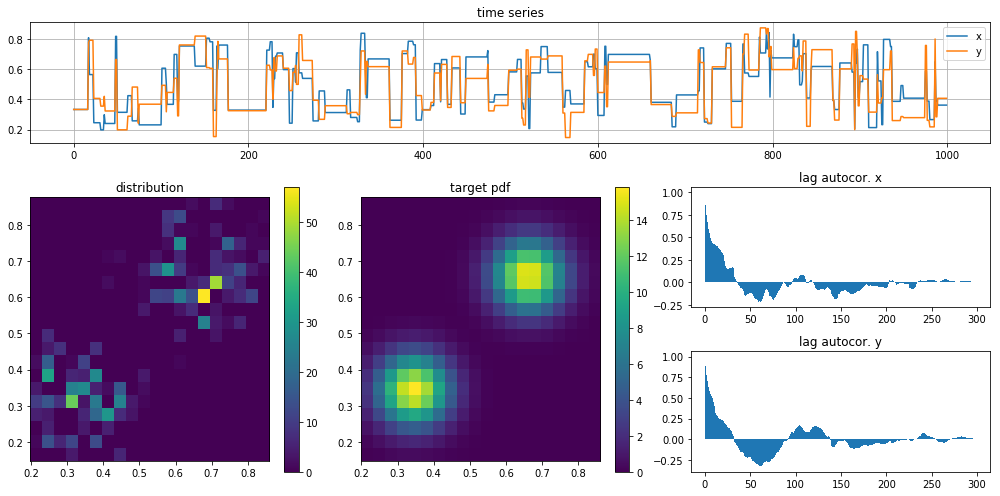

In [3]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

# by default the range for Uniform ins [0, 1]^ndim
proposal = densities.Uniform(ndim)
sampler = DefaultMetropolis(ndim, target.pdf, proposal)

# sample
t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

# print info
print('time: ', t_end - t_start)
print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample  # show sample

## Adaptive Metropolis

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  0.4413674050010741
pdf calss:  2000
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.48581885 0.49530369],[0.02842304 0.03159447],None,0.179


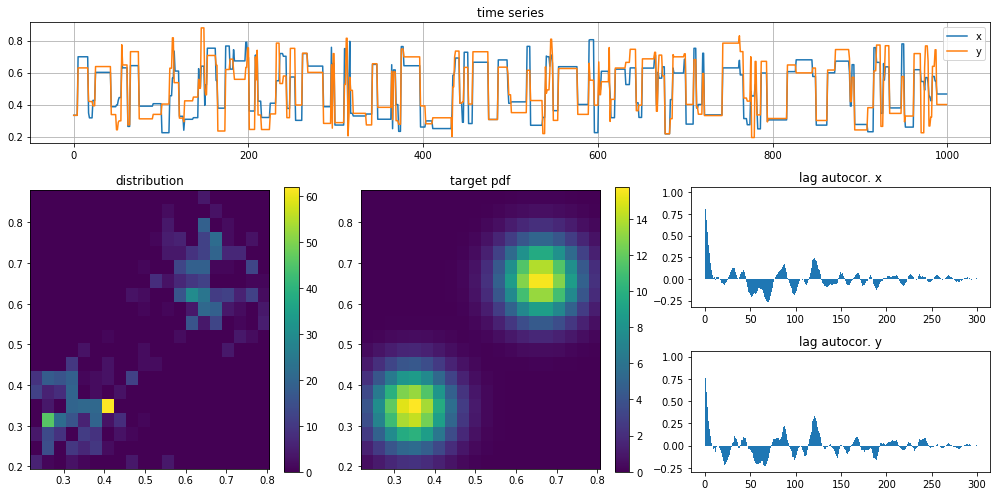

In [6]:
nadapt = 1000
nburnin = 1000

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

# hast to be a proposal with cov attribute
# this is what adaptive metropolis modifies
proposal = densities.Gaussian(ndim, mu=0.5, cov=0.005)
metropolis_sampler = AdaptiveMetropolisUpdate(
    ndim, target.pdf, proposal, t_initial=100,
    adapt_schedule=lambda t: t <= nadapt)

# burn in
metropolis_sampler.sample(nburnin, start, log_every=0)
metropolis_sampler.is_adaptive = False  # turn adaptation off

t_start = timer()
sample = metropolis_sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Hamiltonian Updates
Hamiltonian updates take densities as argument, and therefore don't require a dedicated ndim argument.

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  23.854571523999766
pdf calss:  31969
pot_gradient calls:  131938


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.42657139 0.42795749],[0.02695785 0.02680412],None,0.997


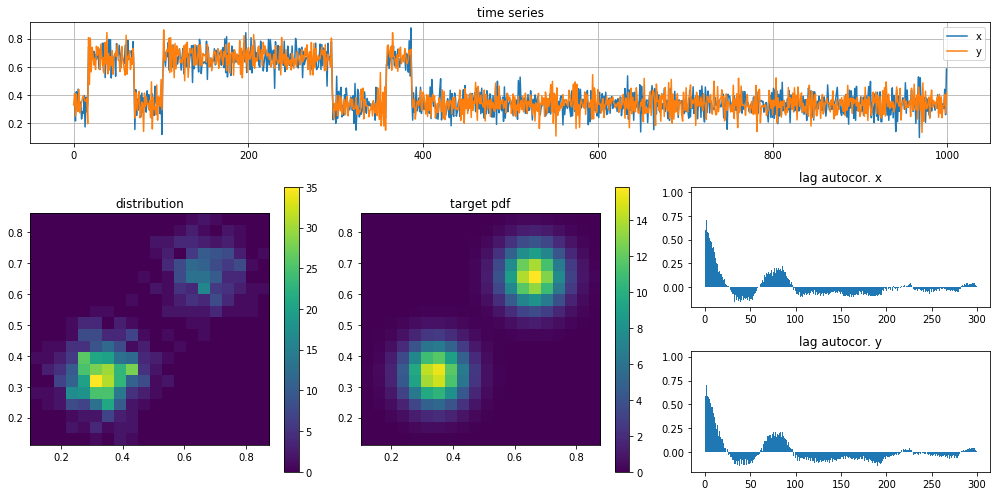

In [16]:
step_size = 0.1
steps = 30

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=10)
sampler = hamiltonian.HamiltonianUpdate(target, momentum_dist, steps, step_size)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Dual Averaging HMC

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  2.2062968550017104
pdf calss:  3001
pot_gradient calls:  14989


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.33946276 0.33247179],[0.00388118 0.00383122],None,0.5


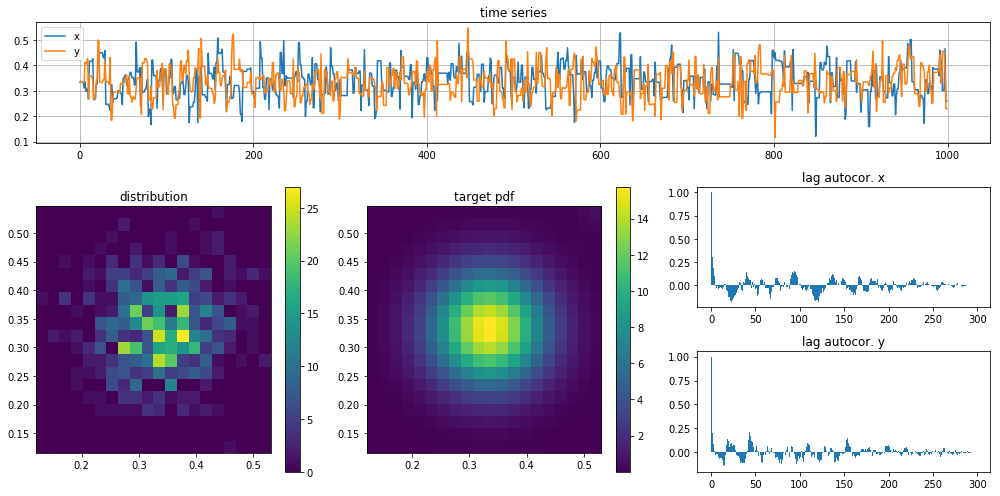

In [9]:
nadapt = 1000

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=.05)
sampler = hamiltonian.DualAveragingHMC(target, momentum_dist, 1, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## No-U-turn sampler

/home/mathis/Dev/bachelor/main/monte_carlo/hamiltonian/nuts.py:83: RuntimeWarning: invalid value encountered in true_divide
  if np.random.uniform() < n_2prime/(n_prime + n_2prime):


Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  25.64358275801351
pdf calss:  44474
pot_gradient calls:  58863


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.33386742 0.33064435],[0.00218038 0.00186658],None,0.953


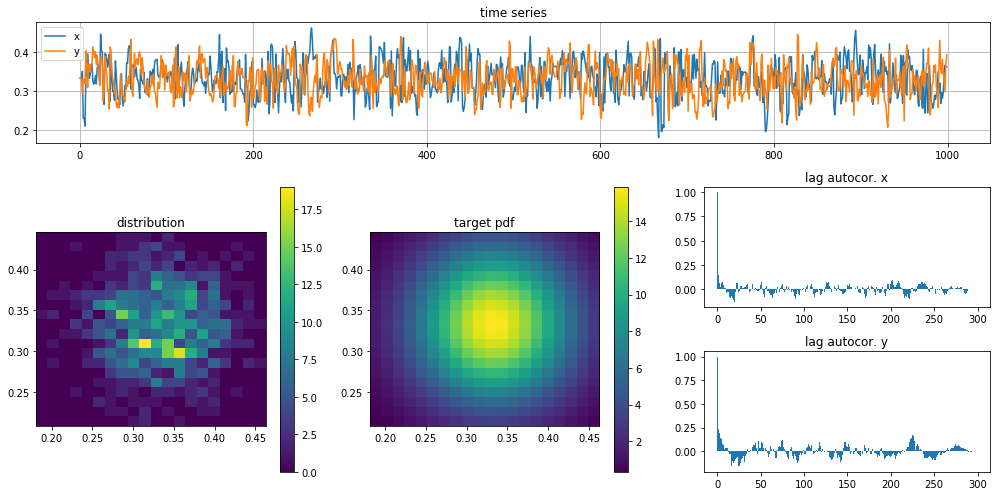

In [11]:
nadapt = 100

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=50)
sampler = hamiltonian.NUTSUpdate(target, momentum_dist, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Spherical HMC
Sampling is by implementation restrained to $[0, 1]^{ndim}$.

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  8.950488997012144
pdf calss:  8825
pot_gradient calls:  66688


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.4897469 0.4848144],[0.03043949 0.03186813],None,0.402


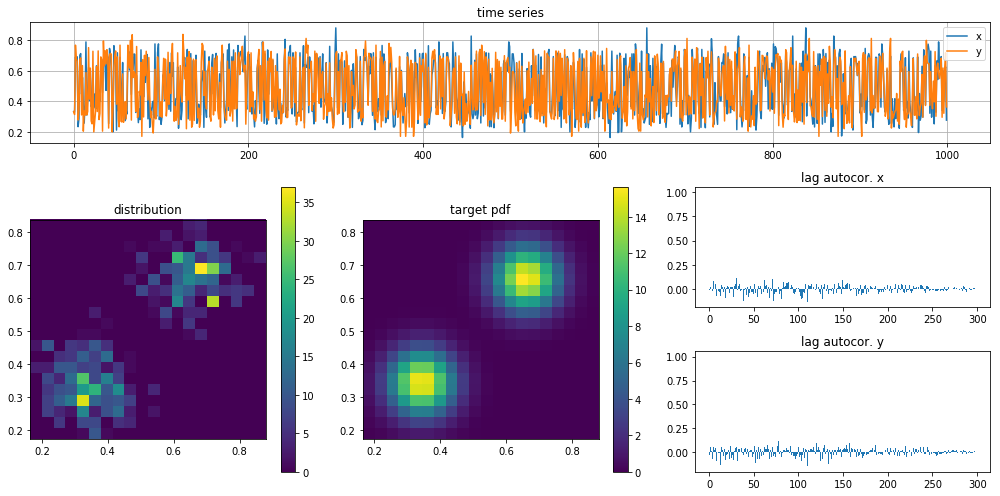

In [12]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

sampler = hamiltonian.StaticSphericalHMC(target, 0.01, 1, 1, 15)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Spherical NUTS

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  8.796387109992793
pdf calss:  15222
pot_gradient calls:  73795


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.33403746 0.33687358],[0.00448414 0.00426335],None,0.911


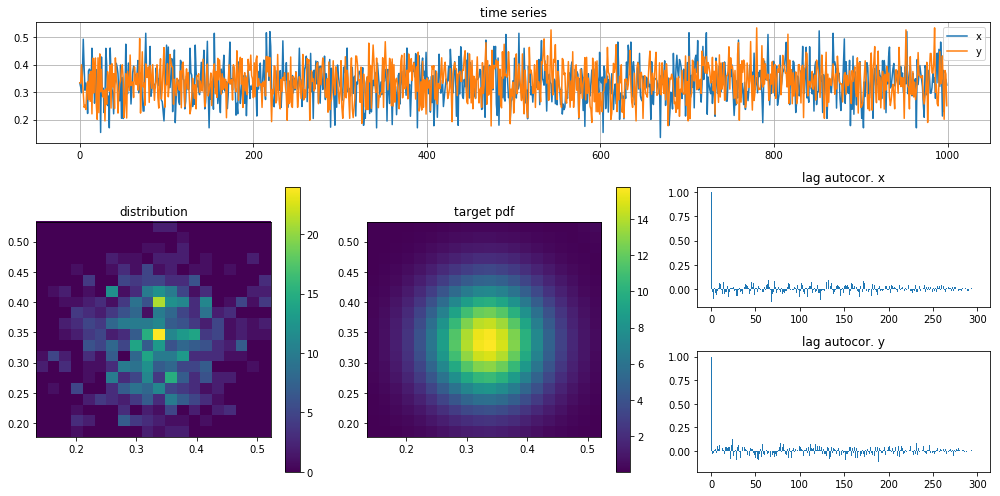

In [13]:
nadapt = 100

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

sampler = hamiltonian.SphericalNUTS(target, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

# Importance Sampling - Metropolis

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.62774866 0.6328543 ],[0.03877511 0.03829287],None,0.226


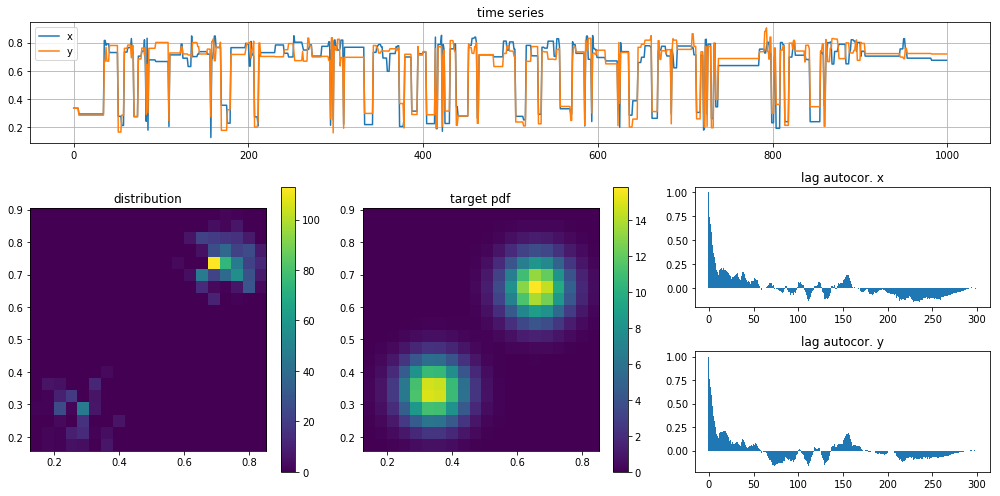

In [19]:
nopt = 1000  # integration steps

# imperfect channels
channels = MultiChannel([
    densities.Gaussian(ndim, mu=1/5, cov=0.005),
    densities.Gaussian(ndim, mu=4/5, cov=0.005)])

# multi channel integrator
importance = MultiChannelMC(channels)

t_start = timer()
integration_sample = importance(target, [], [nopt], []) # integrate

sampler = DefaultMetropolis(ndim, target.pdf, channels)
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

sample

## MC 3

Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.52665666 0.50671309],[0.03577117 0.03879918],None,0.246


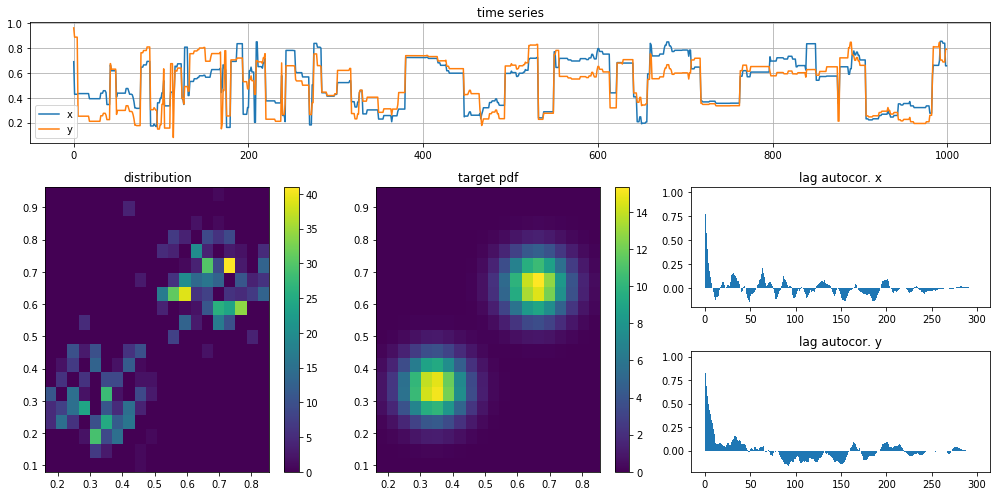

In [3]:
dist = [densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)]
sampler = mc3.MC3Uniform(target, MultiChannel(dist), 0.1, beta=.8)
sample = sampler(([], [1000], []), nsamples)
sample.target = target
sample

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calss:  9880
pot_gradient calls:  7876


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.49795353 0.4992609 ],[0.03085605 0.03292576],None,0.752


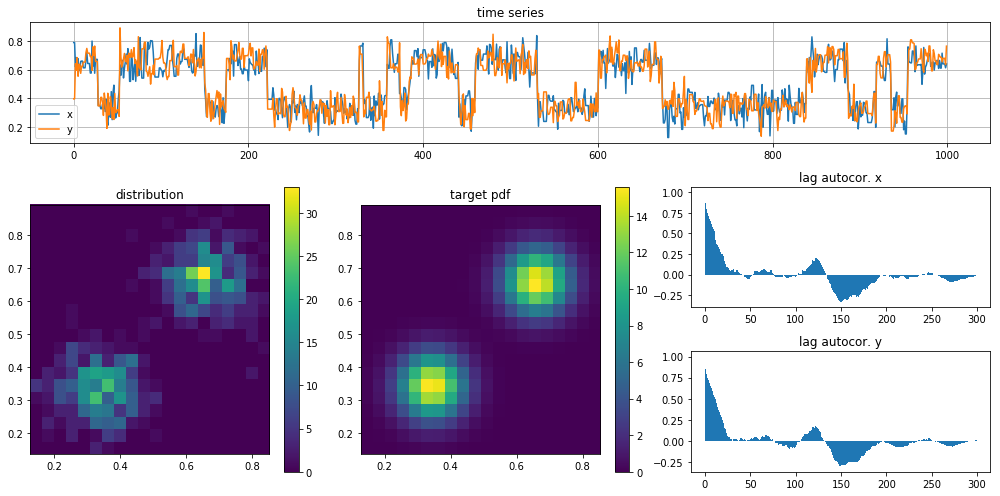

In [4]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

dist = [densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)]
sampler = mc3.MC3Hamilton(target, MultiChannel(dist), 10, 10, .1, beta=.3)
sample = sampler(([], [1000], []), nsamples, log_every=nsamples/4)
sample.target = target

print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calls:  0
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.54035814 0.54377168],[0.02997653 0.03041408],None,0.868


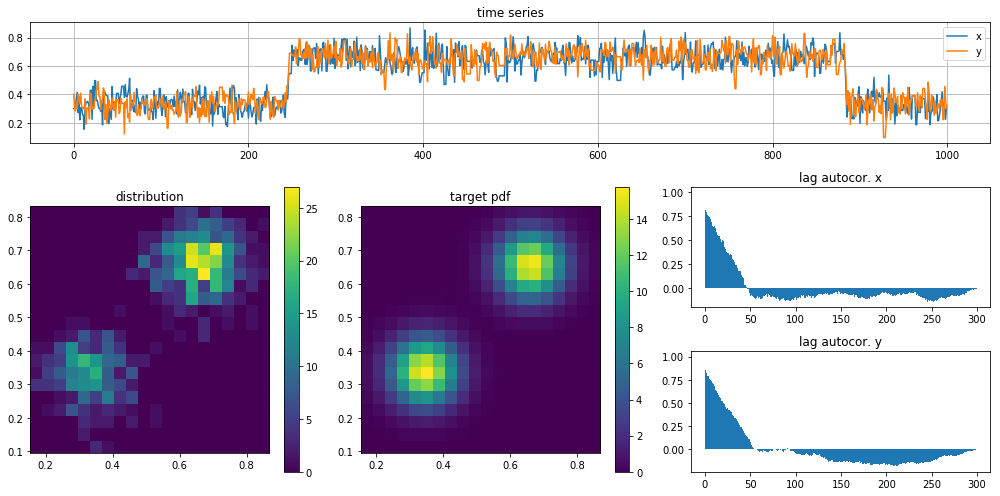

In [5]:
steps = 10
step_size = 0.1
mass = 10
beta = 0
nodes = 1000

# reset counts
target_s = densities.Camel(ndim)

# importance
channels = MultiChannel([densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)])
mc_importance = MultiChannelMC(channels)
integration_sample = mc_importance(target_s, [], [10000], [])

# surrogate
basis = surrogate.extreme_learning.TrigBasis(ndim)
log_vals = -np.ma.log(integration_sample.function_values)
xvals = integration_sample.data[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

params = basis.extreme_learning_train(xvals, log_vals, nodes)
def surr(xs):
    return basis.eval_gradient(*params, xs)
target_s.pot_gradient = surr


# sampling
p_dist = densities.Gaussian(channels.ndim, scale=mass)
sample_hmc = hamiltonian.HamiltonianUpdate(target_s, p_dist, steps, step_size)

sample_is = DefaultMetropolis(ndim, target_s.pdf, channels)

updates = [sample_is, sample_hmc]
mixing_sampler = MixingMarkovUpdate(ndim, updates, [beta, 1-beta])


sample = mixing_sampler.sample(nsamples, [0.3, 0.4], log_every=nsamples/4)
sample.target = target

print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

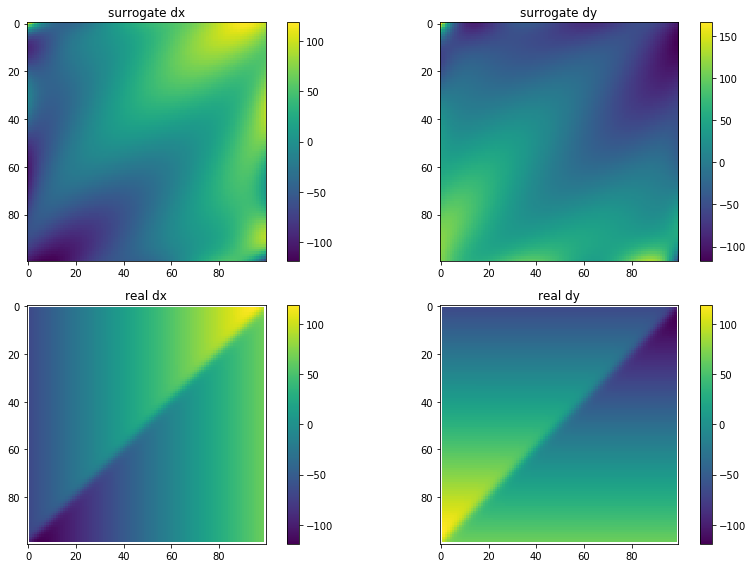

In [9]:
# plot 
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

# fit
out = basis.eval_gradient_split(*params, *mgrid)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title("surrogate dx")
plt.imshow(out[:,:,0])
plt.colorbar()

plt.subplot(222)
plt.title("surrogate dy")
plt.imshow(out[:,:,1])
plt.colorbar()

grad = target.pot_gradient(np.stack((mgrid[0].flatten(), mgrid[1].flatten()), axis=0).transpose()).reshape((*mgrid[0].shape, 2))
plt.subplot(223)
plt.title("real dx")
plt.imshow(grad[:,:,0])
plt.colorbar()

plt.subplot(224)
plt.title("real dy")
plt.imshow(grad[:,:,1])
plt.colorbar()

plt.tight_layout()
plt.show()

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calls:  33969
pot_gradient calls:  131938


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.43619961 0.43652087],[0.02891852 0.02953452],None,0.886


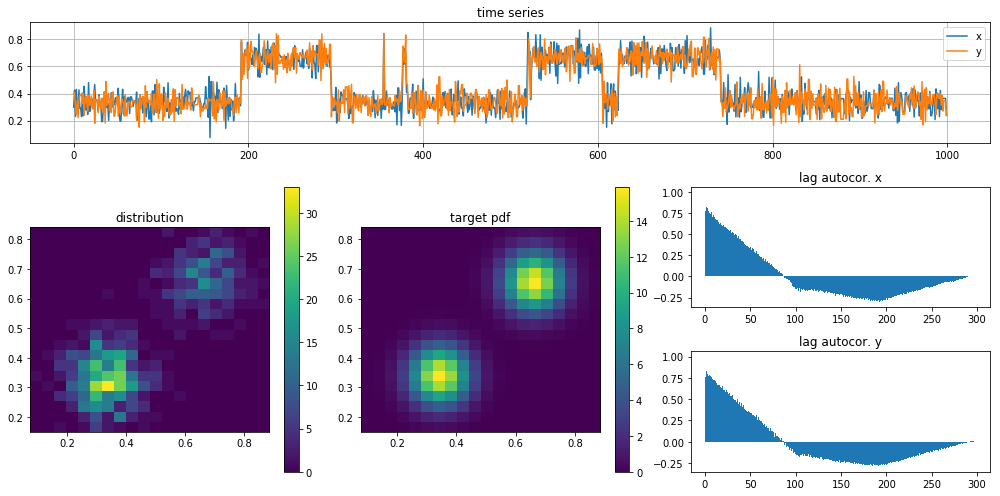

In [21]:
steps = 30
step_size = 0.1
mass = 10
beta = 0.1
nodes = 1000

# reset counts
target_s = densities.Camel(ndim)

# importance
channels = MultiChannel([densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)])
mc_importance = MultiChannelMC(channels)
integration_sample = mc_importance(target_s, [], [10000], [])

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(ndim)
log_vals = -np.ma.log(integration_sample.function_values)
xvals = integration_sample.data[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

params = basis.extreme_learning_train(xvals, log_vals, nodes)
def surr(xs):
    return basis.eval_gradient(*params, xs)
target_s.pot_gradient = surr


# sampling
p_dist = densities.Gaussian(channels.ndim, scale=mass)
sample_hmc = hamiltonian.HamiltonianUpdate(target_s, p_dist, steps, step_size)

sample_is = DefaultMetropolis(ndim, target_s.pdf, channels)

updates = [sample_is, sample_hmc]
mixing_sampler = MixingMarkovUpdate(ndim, updates, [beta, 1-beta])


sample = mixing_sampler.sample(nsamples, [0.3, 0.4], log_every=nsamples/4)
sample.target = target

print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

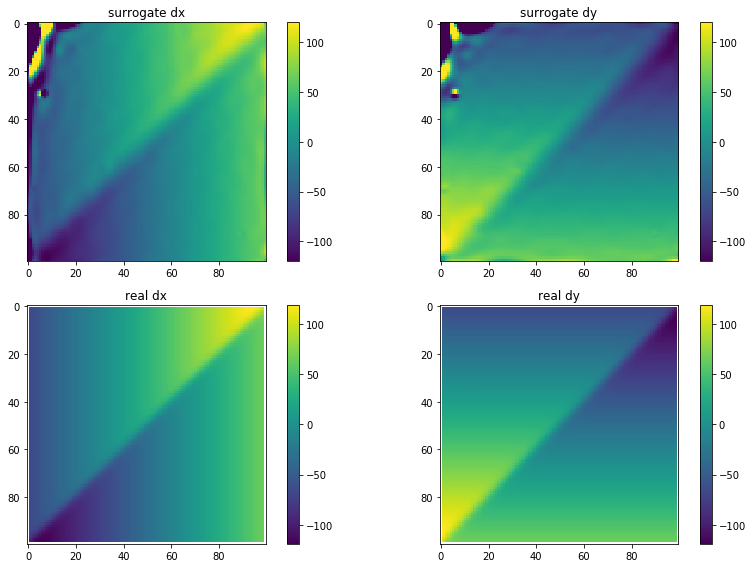

In [22]:
# plot 
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

# fit
out = basis.eval_gradient_split(*params, *mgrid)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title("surrogate dx")
plt.imshow(out[:,:,0], vmin=-120, vmax=120)
plt.colorbar()

plt.subplot(222)
plt.title("surrogate dy")
plt.imshow(out[:,:,1], vmin=-120, vmax=120)
plt.colorbar()

grad = target.pot_gradient(np.stack((mgrid[0].flatten(), mgrid[1].flatten()), axis=0).transpose()).reshape((*mgrid[0].shape, 2))
plt.subplot(223)
plt.title("real dx")
plt.imshow(grad[:,:,0])
plt.colorbar()

plt.subplot(224)
plt.title("real dy")
plt.imshow(grad[:,:,1])
plt.colorbar()

plt.tight_layout()
plt.show()